# Importamos las librerías y leemos los archivos correspondientes a enero, febrero, marzo y el CSV que nos brindó la cátedra.

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Leo los archivos
januaryTaxis = pq.read_table('yellow_tripdata_2024-01.parquet')
februaryTaxis = pq.read_table('yellow_tripdata_2024-02.parquet')
marchTaxis = pq.read_table('yellow_tripdata_2024-03.parquet')

januaryTaxis = januaryTaxis.to_pandas()
februaryTaxis = februaryTaxis.to_pandas()
marchTaxis = marchTaxis.to_pandas()

print("Número de registros de enero:", len(januaryTaxis))
print("Número de registros de febrero:", len(februaryTaxis))
print("Número de registros de marzo:", len(marchTaxis))

taxi_zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
print("Número de registros: CSV", len(taxi_zone_lookup))

Número de registros de enero: 2964624
Número de registros de febrero: 3007526
Número de registros de marzo: 3582628
Número de registros: CSV 265


# Juntamos la información de los 3 meses en un único DataFrame

Lo siguiente que haremos es combinar la información de nuestro DataFrame trimestral con la información provista por la cátedra. Vemos que en el archivo .CSV que nos proveyeron, tenemos un LocationID que tiene asociado un Borough (municipio), una Zone y una service_zone. A partir de esta información, vamos a reemplazar los valores PULocationID y DOLocationID del DataFrame con la información que encontramos en el csv, ya que nos permitirá obtener información valiosa sobre los datos además de volverlos mucho más prácticos para trabajar que andar obteniendo Ids y corroborando a qué valores representan.

In [2]:
#Concateno la información de los 3 meses en un unico DataFrame
taxiTrimestralData = pd.concat([januaryTaxis, februaryTaxis, marchTaxis], ignore_index=True)

# Creamos un DataFrame unicamente para los comienzos de viajes
pickup_zone = taxi_zone_lookup.rename(columns={
    'LocationID': 'PULocationID',
    'Borough': 'PUBorough',
    'Zone': 'PUZone',
    'service_zone': 'PUservice_zone'
})

# Creamos un DataFrame unicamente para los descensos
dropoff_zone = taxi_zone_lookup.rename(columns={
    'LocationID': 'DOLocationID',
    'Borough': 'DOBorough',
    'Zone': 'DOZone',
    'service_zone': 'DOservice_zone'
})

# Merge para la ubicación de pickup
taxiTrimestralData = taxiTrimestralData.merge(
    pickup_zone[['PULocationID', 'PUBorough', 'PUZone', 'PUservice_zone']],
    on='PULocationID',
    how='left'
)

# Merge para la ubicación de dropoff
taxiTrimestralData = taxiTrimestralData.merge(
    dropoff_zone[['DOLocationID', 'DOBorough', 'DOZone', 'DOservice_zone']],
    on='DOLocationID',
    how='left'
)

# Paso 4: Eliminar las columnas originales de IDs
taxiTrimestralData.drop(columns=['PULocationID', 'DOLocationID'], inplace=True)

# Verificamos el resultado
print(taxiTrimestralData.head())
print("Número de registros:", len(taxiTrimestralData))
print(taxiTrimestralData.dtypes)


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  payment_type  fare_amount  \
0           1.72         1.0                  N             2         17.7   
1           1.80         1.0                  N             1         10.0   
2           4.70         1.0                  N             1         23.3   
3           1.40         1.0                  N             1         10.0   
4           0.80         1.0                  N             1          7.9   

   extra  ...  improvement_surcharge  total_amount  congestion_surcharge  \
0   

<Axes: >

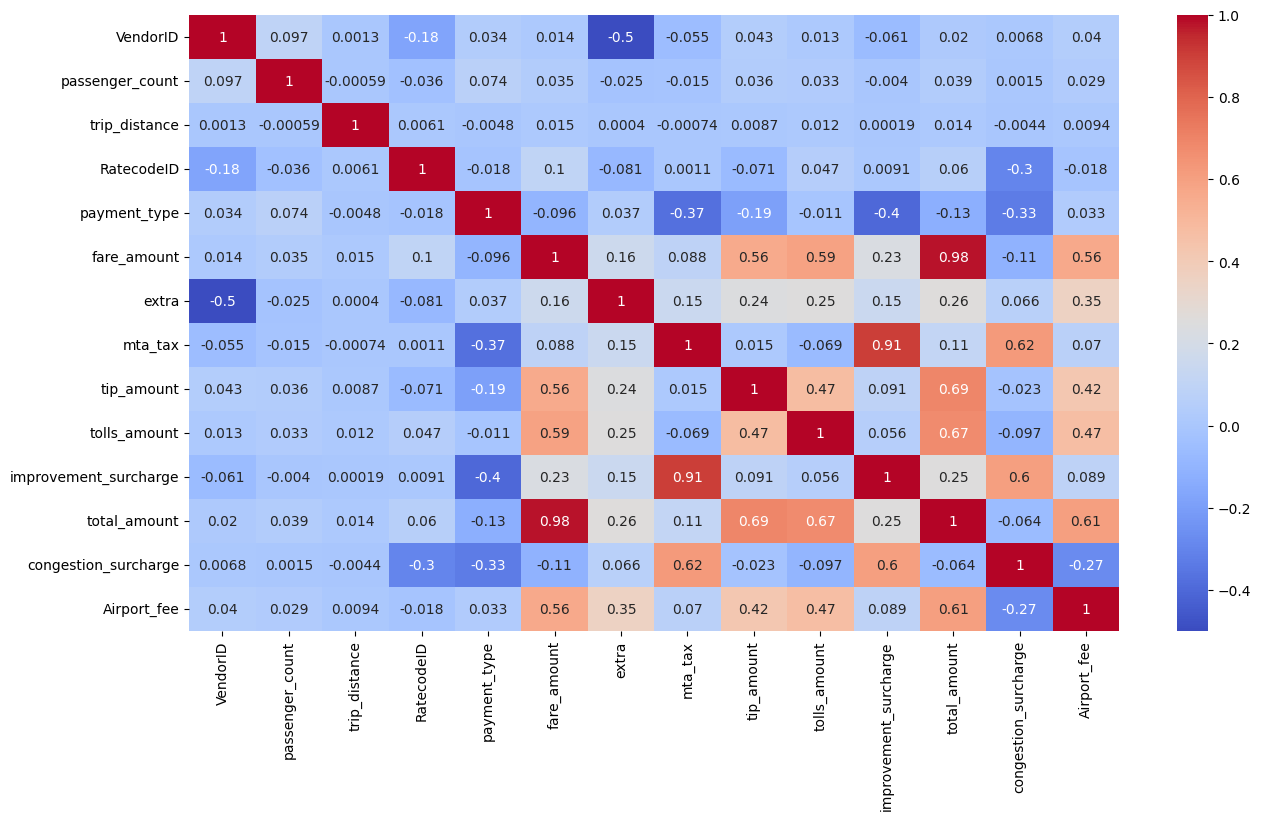

In [43]:
#Matriz de Correlatividad
matriz_corr=taxiTrimestralData.corr(numeric_only=True)
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')

datos faltantes

In [3]:
#Nos fijamos cual es el porcentaje de nulos que hay en las columnas que los contienen

#Cantidad de registros
cantidad_registros = len(taxiTrimestralData)
print("cantidad de registros: {}".format(cantidad_registros))

# Obtener una serie booleana que indica columnas con valores nulos
columnas_con_nulos = taxiTrimestralData.isnull().any()
print("columnas con nulos:{}".format(columnas_con_nulos))

# Filtrar las columnas que tienen valores nulos
columnas_con_nulos = columnas_con_nulos[columnas_con_nulos].index
print("columnas con nulos ya filtrados: {}".format(columnas_con_nulos))

# Crear un nuevo DataFrame con las columnas que tienen valores nulos
nuevo_df = taxiTrimestralData[columnas_con_nulos]
print("nuevo df: {}".format(nuevo_df.head()))

for nombre_columna, columna in nuevo_df.items():
  valores_Nulos = columna.isnull().sum()
  print("El porcentaje de valores nulos para la columna {} es aproximadamente: {}% ".format(nombre_columna, round(valores_Nulos * 100 / cantidad_registros, 2)))


cantidad de registros: 9554778
columnas con nulos:VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count           True
trip_distance            False
RatecodeID                True
store_and_fwd_flag        True
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge      True
Airport_fee               True
PUBorough                 True
PUZone                    True
PUservice_zone            True
DOBorough                 True
DOZone                    True
DOservice_zone            True
dtype: bool
columnas con nulos ya filtrados: Index(['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'congestion_surcharge', 'Airport_fee', 'PUBorough', 'PUZone',
       'PUservice_zone', 'DOBorough', 'DOZone', 'DOservice_zo

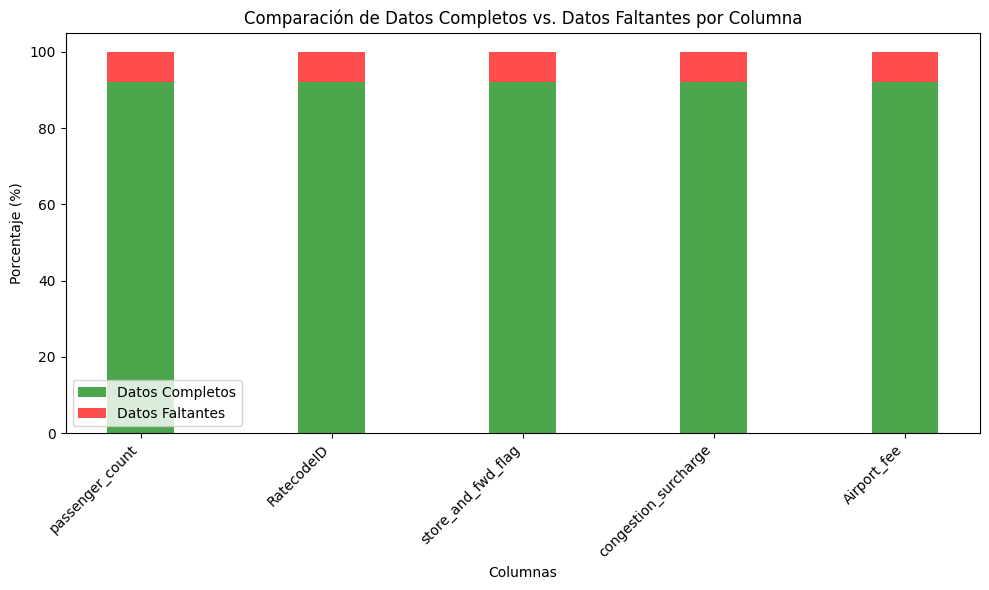

Porcentaje de datos faltantes en passenger_count: 7.87%
Porcentaje de datos faltantes en RatecodeID: 7.87%
Porcentaje de datos faltantes en store_and_fwd_flag: 7.87%
Porcentaje de datos faltantes en congestion_surcharge: 7.87%
Porcentaje de datos faltantes en Airport_fee: 7.87%


In [4]:
columnas_objetivo = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge', 'Airport_fee']
faltantes_locations = ['PUBorough', 'PUZone', 'PUservice_zone', 'DOBorough', 'DOZone', 'DOservice_zone']

# Inicializar listas para almacenar los porcentajes de datos faltantes y completos
porcentajes_faltantes = []
porcentajes_completos = []

# Calcular el número total de datos en el dataset
total_datos = taxiTrimestralData.size

# Calcular los porcentajes para cada columna de interés
for columna in columnas_objetivo:
    datos_faltantes = taxiTrimestralData[columna].isnull().sum()
    porcentaje_faltantes = (datos_faltantes / len(taxiTrimestralData)) * 100
    porcentaje_completos = 100 - porcentaje_faltantes
    porcentajes_faltantes.append(porcentaje_faltantes)
    porcentajes_completos.append(porcentaje_completos)

# Crear un gráfico de barras apiladas para cada columna de interés
plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = range(len(columnas_objetivo))
plt.bar(indices, porcentajes_completos, bar_width, label='Datos Completos', color='green', alpha=0.7)
plt.bar(indices, porcentajes_faltantes, bar_width, bottom=porcentajes_completos, label='Datos Faltantes', color='red', alpha=0.7)
plt.xlabel('Columnas')
plt.ylabel('Porcentaje (%)')
plt.title('Comparación de Datos Completos vs. Datos Faltantes por Columna')
plt.xticks(indices, columnas_objetivo, rotation=45, ha='right')  # Rotar etiquetas
plt.legend()
plt.tight_layout()  # Ajustar diseño automáticamente
plt.show()

# Imprimir los porcentajes de datos faltantes en cada columna
for i, columna in enumerate(columnas_objetivo):
    print(f"Porcentaje de datos faltantes en {columna}: {porcentajes_faltantes[i]:.2f}%")


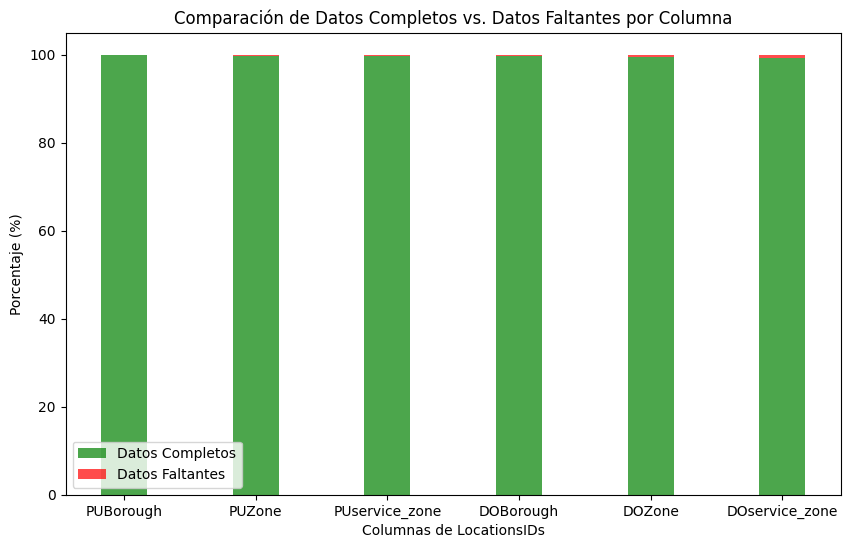

Porcentaje de datos faltantes en PUBorough: 0.05%
Porcentaje de datos faltantes en PUZone: 0.33%
Porcentaje de datos faltantes en PUservice_zone: 0.38%
Porcentaje de datos faltantes en DOBorough: 0.38%
Porcentaje de datos faltantes en DOZone: 0.51%
Porcentaje de datos faltantes en DOservice_zone: 0.89%


In [5]:
porcentajes_faltantes = []
porcentajes_completos = []
indices = 0

# Calcular los porcentajes para cada columna de interés
for columna_locations in faltantes_locations:
    datos_faltantes = taxiTrimestralData[columna_locations].isnull().sum()
    porcentaje_faltantes = (datos_faltantes / len(taxiTrimestralData)) * 100
    porcentaje_completos = 100 - porcentaje_faltantes
    porcentajes_faltantes.append(porcentaje_faltantes)
    porcentajes_completos.append(porcentaje_completos)

# Crear un gráfico de barras apiladas para cada columna de interés
plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = range(len(faltantes_locations))
plt.bar(indices, porcentajes_completos, bar_width, label='Datos Completos', color='green', alpha = 0.7)
plt.bar(indices, porcentajes_faltantes, bar_width, bottom=porcentajes_completos, label='Datos Faltantes', color='red', alpha = 0.7)
plt.xlabel('Columnas de LocationsIDs')
plt.ylabel('Porcentaje (%)')
plt.title('Comparación de Datos Completos vs. Datos Faltantes por Columna')
plt.xticks(indices, faltantes_locations)
plt.legend()
plt.show()

# Imprimir los porcentajes de datos faltantes en cada columna
for i, columna in enumerate(faltantes_locations):
    print(f"Porcentaje de datos faltantes en {columna}: {porcentajes_faltantes[i]:.2f}%")

In [6]:
#Convierto los None a un nan
taxiTrimestralData = taxiTrimestralData.replace({None: np.nan})

In [7]:
#Imputamos los datos faltantes
from sklearn.impute import SimpleImputer

numericas = taxiTrimestralData.select_dtypes(include=['int64', 'float64']).columns
imputador_numerico = SimpleImputer(strategy='median')
taxiTrimestralData[numericas] = imputador_numerico.fit_transform(taxiTrimestralData[numericas])

categoricas = taxiTrimestralData.select_dtypes(include=['object']).columns
imputador_categorico = SimpleImputer(strategy='most_frequent')
taxiTrimestralData[categoricas] = imputador_categorico.fit_transform(taxiTrimestralData[categoricas])

In [8]:
filas_totales = taxiTrimestralData.shape[0]
print("Porcentajes de datos faltantes:")
porcentaje_por_columna = taxiTrimestralData.isna().sum() / filas_totales * 100
print(porcentaje_por_columna)

Porcentajes de datos faltantes:
VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
Airport_fee              0.0
PUBorough                0.0
PUZone                   0.0
PUservice_zone           0.0
DOBorough                0.0
DOZone                   0.0
DOservice_zone           0.0
dtype: float64


# Valores numéricos discretos

A continuación vamos a analizar en las variables con tipos de datos númericos la existencia de registros mal ingresados o que carecen de sentido segun la naturaleza de lo que representen.

In [9]:
# Crear una lista de DataFrames individuales para cada columna
resultados = []

#Columnas discretas con rangos especificos:

#Columna que representa el proveedor del viaje. Debe tener un valor entre 1 y 2.
columna_vendor_mal_ingresados = (taxiTrimestralData['VendorID'] != 1) & (taxiTrimestralData['VendorID'] != 2)
resultados.append(pd.DataFrame({'columna': ['VendorID'], 'valores mal ingresados': [columna_vendor_mal_ingresados.sum()]}))

#Columna que representa la cantidad de pasajeros de un viaje. Un viaje con menos de 1 pasajero no tiene sentido,
# y un viaje con más de 4 tampoco es posible.
columna_pasajeros_mal_ingresados = (taxiTrimestralData['passenger_count'] <= 0) | (taxiTrimestralData['passenger_count'] > 4)
resultados.append(pd.DataFrame({'columna': ['passenger_count'], 'valores mal ingresados': [columna_pasajeros_mal_ingresados.sum()]}))

#Las distancias negativas no son posibles, y tomaremos un umbral de 45 millas teniendo en cuenta la longitud aproximada de NYC.
columna_distancia_mal_ingresada = ((taxiTrimestralData['trip_distance'] <= 0) | (taxiTrimestralData['trip_distance'] > 45))
resultados.append(pd.DataFrame({'columna': ['trip_distance'], 'valores mal ingresados': [columna_distancia_mal_ingresada.sum()]}))

#RatecodeID y payment_type deberá tener un valor entre 1 y 6.
columna_ratecodes_mal_ingresados = (taxiTrimestralData['RatecodeID'] <= 0) | (taxiTrimestralData['RatecodeID'] > 6)
resultados.append(pd.DataFrame({'columna': ['RatecodeID'], 'valores mal ingresados': [columna_ratecodes_mal_ingresados.sum()]}))
columna_payment_type_mal_ingresados = ((taxiTrimestralData['payment_type'] <= 0)) | ((taxiTrimestralData['payment_type'] > 6))
resultados.append(pd.DataFrame({'columna': ['payment_type'], 'valores mal ingresados': [columna_payment_type_mal_ingresados.sum()]}))

def marca_valores_binarios_mal_ingresados(valor):
    if valor not in {"Y", "N"}:
        return 1  # Marcar como valor mal ingresado
    else:
        return 0  # Marcar como valor válido

#Columnas con valores booleanos
columna_store_and_fwd =  taxiTrimestralData["store_and_fwd_flag"].apply(marca_valores_binarios_mal_ingresados)
resultados.append(pd.DataFrame({'columna': ['store_and_fwd_flag'], 'valores mal ingresados': [columna_store_and_fwd.sum()]}))

#Las fare_amounts negativas o 0 no son posibles
columna_fare_amount_mal_ingresado = (taxiTrimestralData['fare_amount'] <= 0)
resultados.append(pd.DataFrame({'columna': ['fare_amount'], 'valores mal ingresados': [columna_fare_amount_mal_ingresado.sum()]}))

def es_extra_invalido(valor):
    return not (valor > 0 and (valor * 2).is_integer())

#Los cargos extra pueden ser 0, 0.5 o 1
#columna_extras_mal_ingresados = (taxiTrimestralData['extra'] != 0.5 & taxiTrimestralData['extra'] != 1 & taxiTrimestralData['extra'] != 0)
columna_extras_mal_ingresados = taxiTrimestralData["extra"].apply(es_extra_invalido)
resultados.append(pd.DataFrame({'columna': ['extra'], 'valores mal ingresados': [columna_extras_mal_ingresados.sum()]}))

#Los cargos extra pueden ser 0, 0.5 o 1
columna_airport_fee_mal_ingresados = ((taxiTrimestralData['Airport_fee'] != 0) & (taxiTrimestralData['Airport_fee'] != 1.25))
resultados.append(pd.DataFrame({'columna': ['Airport_fee'], 'valores mal ingresados': [columna_airport_fee_mal_ingresados.sum()]}))


def marca_valores_bool_mal_ingresados(valor):
    if valor not in {0, 1}:
        return 1  # Marcar como valor mal ingresado
    else:
        return 0  # Marcar como valor válido



#Columnas de conteo:
#Dado que representan "cuanto hay de algo" su valor no puede ser menor a 0
columnas_de_conteo = ['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge', 'extra', 'improvement_surcharge']

for columna in columnas_de_conteo:
  columna_conteo_mal_ingresado = (taxiTrimestralData[columna] < 0)
  resultado_columna = pd.DataFrame({'columna': [columna], 'valores mal ingresados': [columna_conteo_mal_ingresado.sum()]})
  resultados.append(resultado_columna)

# Concatenar los DataFrames individuales en uno solo
resultados_df = pd.concat(resultados, ignore_index=True)

print(resultados_df)

                  columna  valores mal ingresados
0                VendorID                     720
1         passenger_count                  269756
2           trip_distance                  217566
3              RatecodeID                   96699
4            payment_type                  751962
5      store_and_fwd_flag                       0
6             fare_amount                  139596
7                   extra                 4457314
8             Airport_fee                  725683
9             fare_amount                  136567
10             tip_amount                     330
11           tolls_amount                    7586
12           total_amount                  115895
13   congestion_surcharge                   95113
14                  extra                   57864
15  improvement_surcharge                  115884


In [10]:
cols = ['VendorID', 'RatecodeID', 'payment_type']

for col in cols:
    taxiTrimestralData[col] = taxiTrimestralData[col].astype(str)

# Función para analizar y reportar la cantidad de registros con los valores específicos
def analizar_valores(columna):
    vacios = (columna == "").sum()
    solo_espacios = columna.apply(lambda x: x.isspace()).sum()
    dash = (columna == "-").sum()
    guion_bajo = (columna == "_").sum()
    return vacios, solo_espacios, dash, guion_bajo

# Iterar por cada columna y mostrar resultados
for col in cols:
    vacios, solo_espacios, dash, guion_bajo = analizar_valores(taxiTrimestralData[col])
    print(f"Columna: {col}")
    print(f"  Valores vacíos (\"\"): {vacios}")
    print(f"  Valores con solo espacios: {solo_espacios}")
    print(f"  Valores '-' : {dash}")
    print(f"  Valores '_' : {guion_bajo}\n")

Columna: VendorID
  Valores vacíos (""): 0
  Valores con solo espacios: 0
  Valores '-' : 0
  Valores '_' : 0

Columna: RatecodeID
  Valores vacíos (""): 0
  Valores con solo espacios: 0
  Valores '-' : 0
  Valores '_' : 0

Columna: payment_type
  Valores vacíos (""): 0
  Valores con solo espacios: 0
  Valores '-' : 0
  Valores '_' : 0



In [11]:
#Filtramos los datos erroneos

columnas_a_convertir = [
    'VendorID', 'RatecodeID',
    'payment_type',
]

for col in columnas_a_convertir:
    taxiTrimestralData[col] = pd.to_numeric(taxiTrimestralData[col], errors='coerce')

condiciones_validas = (
    (taxiTrimestralData['VendorID'].isin([1, 2])) &
    (taxiTrimestralData['passenger_count'] > 0) &
    (taxiTrimestralData['trip_distance'] > 0) &
    (taxiTrimestralData['RatecodeID'].between(1, 6)) &
    (taxiTrimestralData['payment_type'].between(1, 6)) &
    (taxiTrimestralData['store_and_fwd_flag'].isin(["Y", "N"])) &
    (taxiTrimestralData['fare_amount'] > 0) &
    (taxiTrimestralData['extra'].isin([0, 0.5, 1])) &
    (taxiTrimestralData['Airport_fee'].isin([0, 1.25])) &
    (taxiTrimestralData['fare_amount'] >= 0) &
    (taxiTrimestralData['tip_amount'] >= 0) &
    (taxiTrimestralData['tolls_amount'] >= 0) &
    (taxiTrimestralData['total_amount'] >= 0) &
    (taxiTrimestralData['congestion_surcharge'] >= 0) &
    (taxiTrimestralData['extra'] >= 0) &
    (taxiTrimestralData['improvement_surcharge'] >= 0)
)

# Filtrar solo registros válidos
taxiTrimestralData_filtrado = taxiTrimestralData[condiciones_validas].copy()

In [12]:
print(taxiTrimestralData.shape)
print(taxiTrimestralData_filtrado.shape)

(9554778, 23)
(4742335, 23)


#Analizamos las variables y posibles outliers

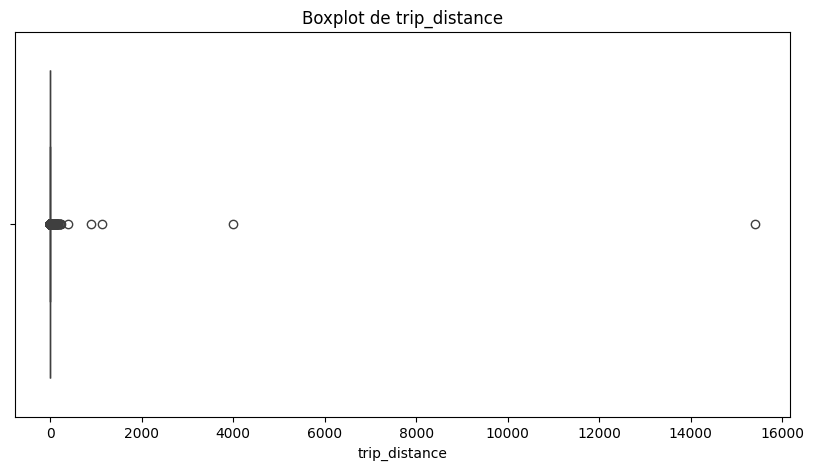

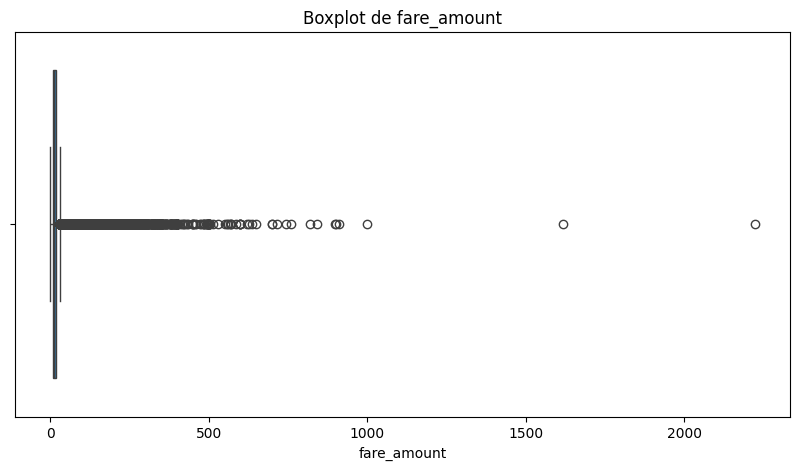

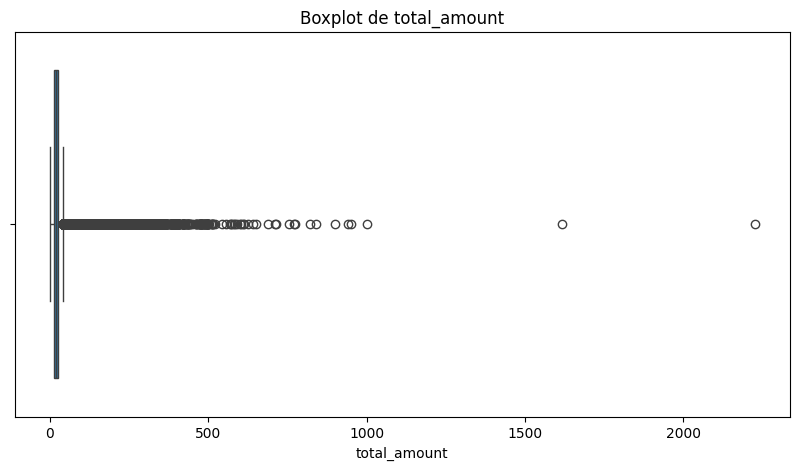

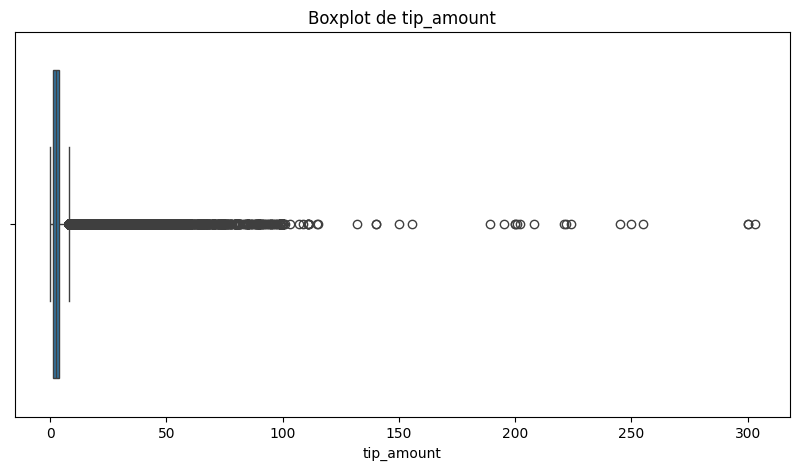

In [13]:
for col in ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=taxiTrimestralData_filtrado[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

In [14]:
#Eliminamos los viajes superiores a 800 millas que los tomamos como errores
taxiTrimestralData_filtrado = taxiTrimestralData_filtrado[taxiTrimestralData['trip_distance'] < 800].copy()

<ipython-input-14-e031f0f391e2>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxiTrimestralData_filtrado = taxiTrimestralData_filtrado[taxiTrimestralData['trip_distance'] < 800].copy()


Ahora hacemos un analisis multivariado como con las siguientes relaciones:

trip_distance y fare_amount: si la tarifa es baja para una gran distancia, puede haber error.

total_amount y passenger_count: analizar si pocos pasajeros pagan montos muy altos.

trip_distance y tip_amount: algunos pasajeros dan tips muy altos en viajes cortos.

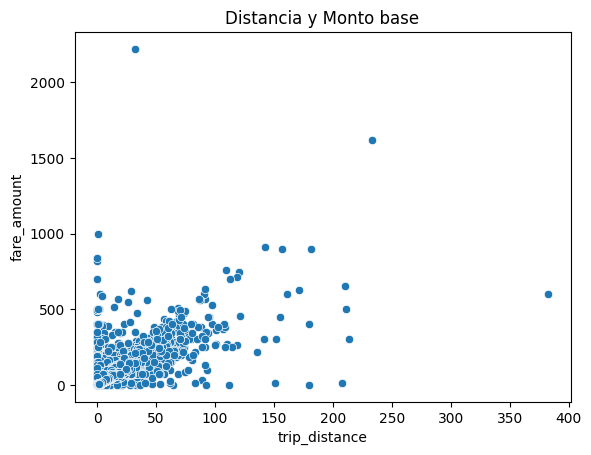

In [15]:
sns.scatterplot(data=taxiTrimestralData_filtrado, x='trip_distance', y='fare_amount')
plt.title('Distancia y Monto base')
plt.show()

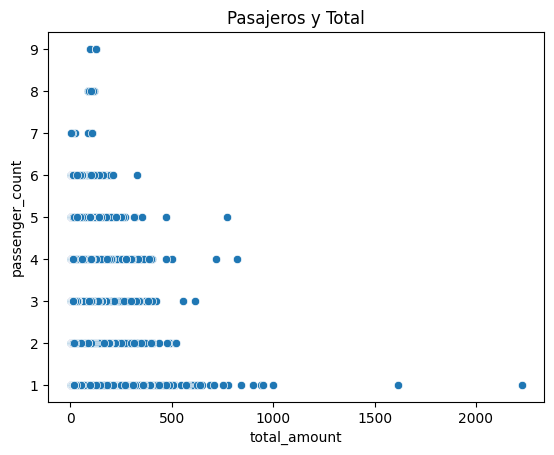

In [18]:
sns.scatterplot(data=taxiTrimestralData_filtrado, x='total_amount', y='passenger_count')
plt.title('Pasajeros y Total')
plt.show()

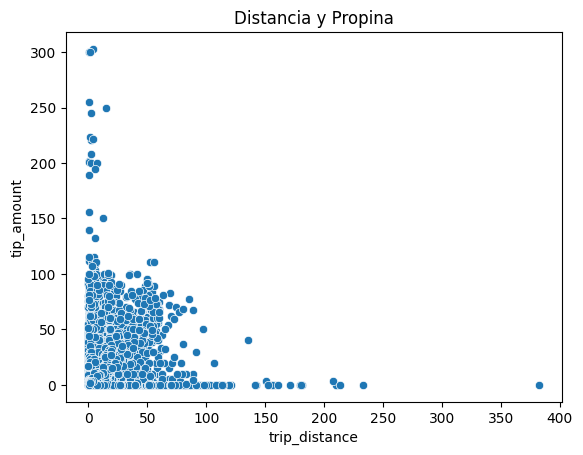

In [19]:
sns.scatterplot(data=taxiTrimestralData_filtrado, x='trip_distance', y='tip_amount')
plt.title('Distancia y Propina')
plt.show()

#Nuevas posibles features

In [16]:
#Tiempo de viaje
taxiTrimestralData_filtrado['trip_time_min'] = (
    pd.to_datetime(taxiTrimestralData['tpep_dropoff_datetime']) -
    pd.to_datetime(taxiTrimestralData['tpep_pickup_datetime'])
).dt.total_seconds() / 60
#Dia y hora del viaje del inicio del viaje
taxiTrimestralData_filtrado['pickup_day'] = pd.to_datetime(taxiTrimestralData['tpep_pickup_datetime']).dt.day_name()
taxiTrimestralData_filtrado['pickup_hour'] = pd.to_datetime(taxiTrimestralData['tpep_pickup_datetime']).dt.hour
#Monto por pasajero
taxiTrimestralData_filtrado['fare_per_passenger'] = taxiTrimestralData_filtrado['fare_amount'] / taxiTrimestralData['passenger_count']

<Axes: xlabel='pickup_hour', ylabel='pickup_day'>

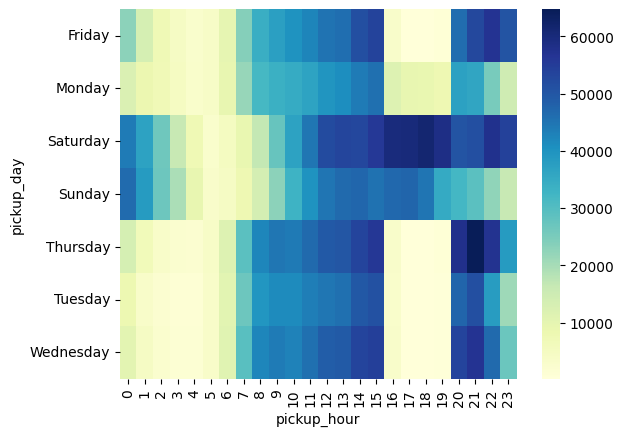

In [17]:
viajes_por_hora_dia = taxiTrimestralData_filtrado.groupby(['pickup_day', 'pickup_hour']).size().unstack()
sns.heatmap(viajes_por_hora_dia, cmap='YlGnBu')

Relacion entre las zonas inicio/fin de viaje

In [18]:
# Crear una nueva columna para los pares de zona de recogida y entrega
taxiTrimestralData['zone_pair'] = taxiTrimestralData['PUZone'].astype(str) + " - " + taxiTrimestralData['DOZone'].astype(str)

# Contar las combinaciones de zonas más frecuentes
zone_pair_counts = taxiTrimestralData['zone_pair'].value_counts()

<ipython-input-19-a1e6e3c4b15c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zone_pair_counts.index[:10], y=zone_pair_counts.values[:10], palette='viridis')


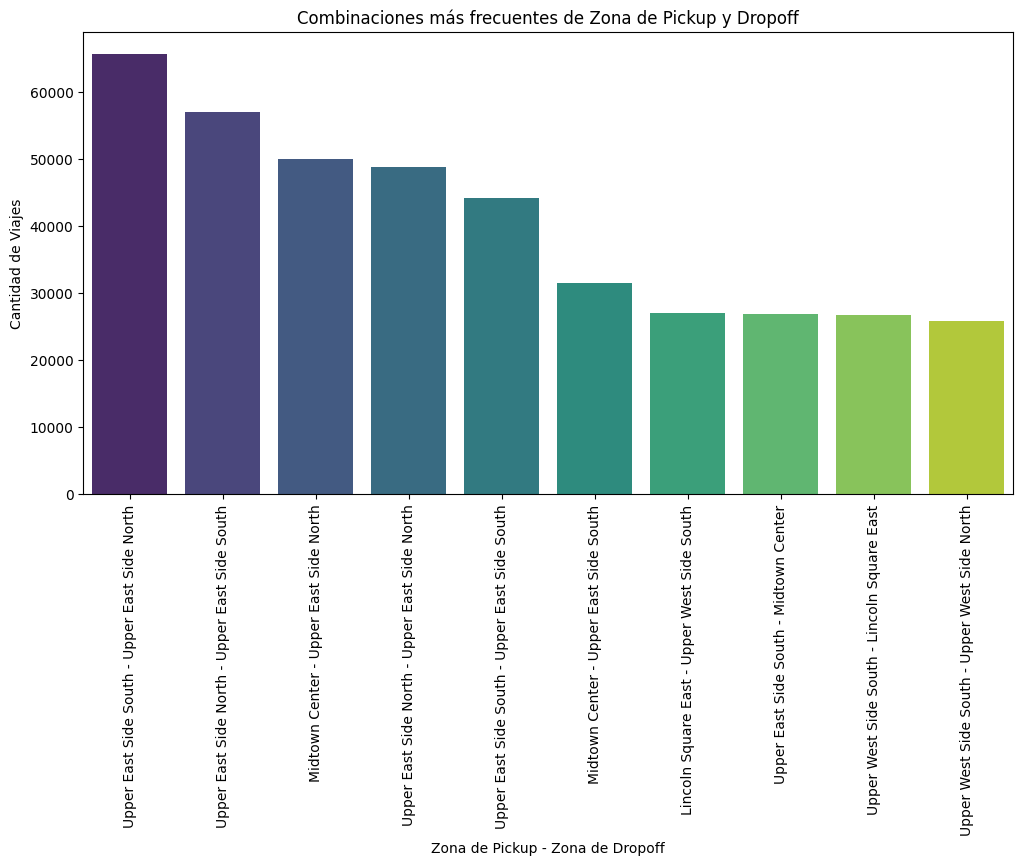

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x=zone_pair_counts.index[:10], y=zone_pair_counts.values[:10], palette='viridis')
plt.title('Combinaciones más frecuentes de Zona de Pickup y Dropoff')
plt.xlabel('Zona de Pickup - Zona de Dropoff')
plt.ylabel('Cantidad de Viajes')
plt.xticks(rotation=90)
plt.show()

Relacion entre el costo por pasajero y la cantidad

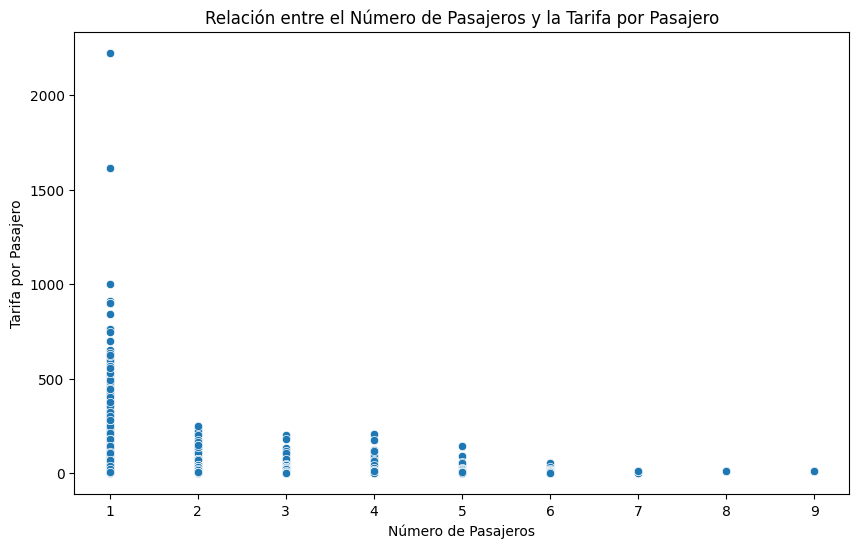

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='fare_per_passenger', data=taxiTrimestralData_filtrado)
plt.title('Relación entre el Número de Pasajeros y la Tarifa por Pasajero')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Tarifa por Pasajero')
plt.show()

Viajes en cuanto distancia, tiempo y precio total

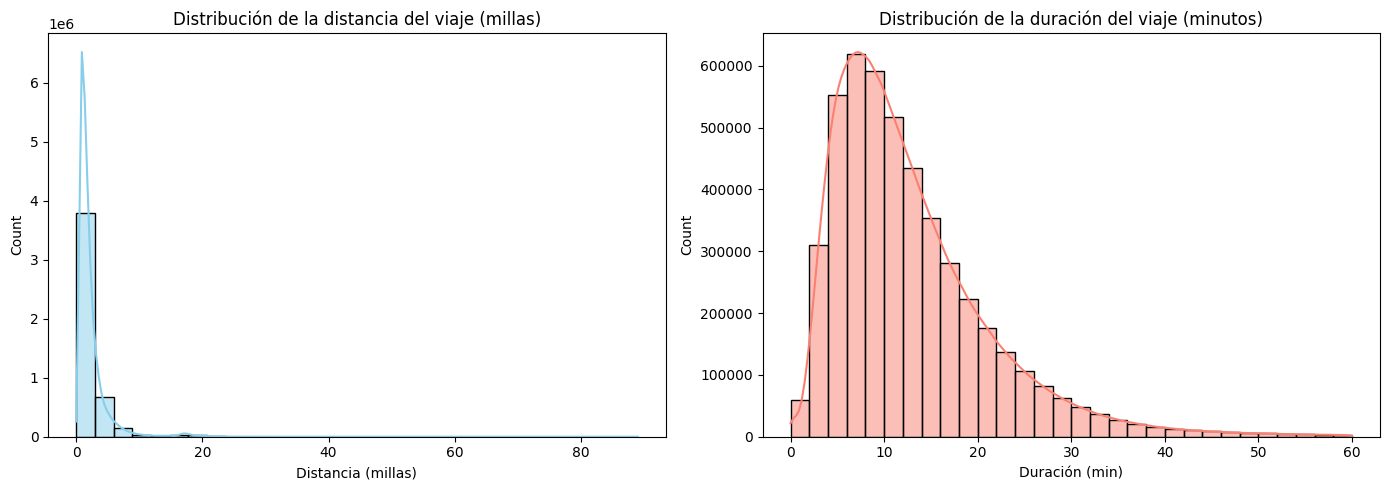

In [28]:
filtered = taxiTrimestralData_filtrado[
    (taxiTrimestralData_filtrado['trip_distance'] <= 100) &
    (taxiTrimestralData_filtrado['trip_time_min'] <= 60)
]

plt.figure(figsize=(14, 5))

# Gráfico de la distancia
plt.subplot(1, 2, 1)
sns.histplot(filtered['trip_distance'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de la distancia del viaje (millas)')
plt.xlabel('Distancia (millas)')

# Gráfico del tiempo de viaje
plt.subplot(1, 2, 2)
sns.histplot(filtered['trip_time_min'], bins=30, kde=True, color='salmon')
plt.title('Distribución de la duración del viaje (minutos)')
plt.xlabel('Duración (min)')

plt.tight_layout()
plt.show()

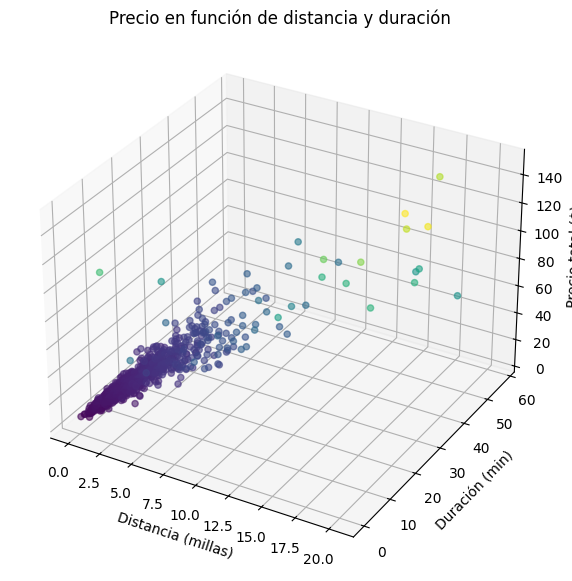

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sample = taxiTrimestralData_filtrado[
    (taxiTrimestralData_filtrado['trip_distance'] < 100) &
    (taxiTrimestralData_filtrado['trip_time_min'] < 60) &
    (taxiTrimestralData_filtrado['total_amount'] < 500)
].sample(1000)

ax.scatter(
    sample['trip_distance'],
    sample['trip_time_min'],
    sample['total_amount'],
    c=sample['total_amount'],
    cmap='viridis',
    alpha=0.6
)

ax.set_xlabel('Distancia (millas)')
ax.set_ylabel('Duración (min)')
ax.set_zlabel('Precio total ($)')
ax.set_title('Precio en función de distancia y duración')
plt.show()

Viaje en cuanto distancia y tiempo según el horario y/o el día de la
semana

<ipython-input-32-0fecece14a36>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=taxiTrimestralData_filtrado, x='pickup_day', y='trip_distance', estimator='mean', ci=None)


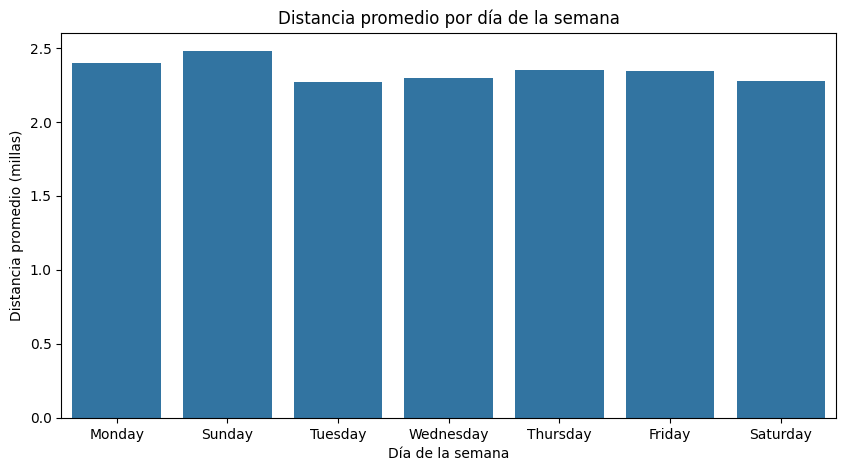

In [32]:
plt.figure(figsize=(10, 5))
sns.barplot(data=taxiTrimestralData_filtrado, x='pickup_day', y='trip_distance', estimator='mean', ci=None)
plt.title('Distancia promedio por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Distancia promedio (millas)')
plt.show()

<ipython-input-34-693fe527e2dc>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=taxiTrimestralData_filtrado, x='pickup_day', y='trip_time_min', estimator='mean', ci=None)


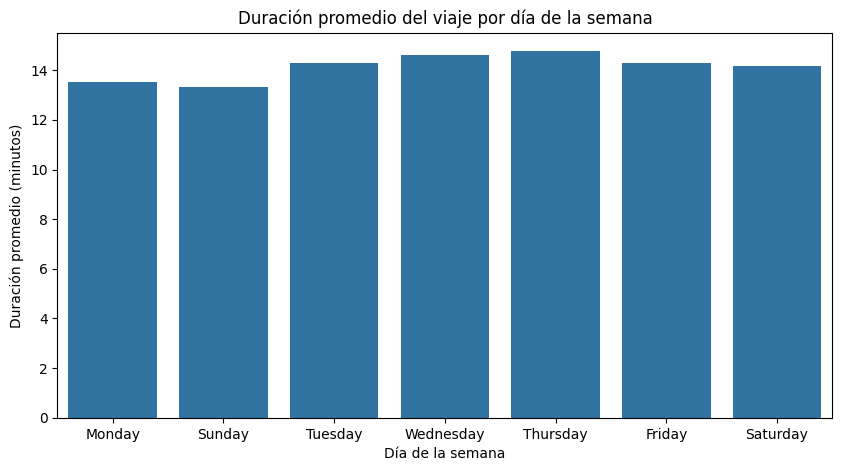

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(data=taxiTrimestralData_filtrado, x='pickup_day', y='trip_time_min', estimator='mean', ci=None)
plt.title('Duración promedio del viaje por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Duración promedio (minutos)')
plt.show()

<ipython-input-36-0802bbd71728>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=taxiTrimestralData_filtrado, x='pickup_hour', y='trip_distance', estimator='mean', ci=None)


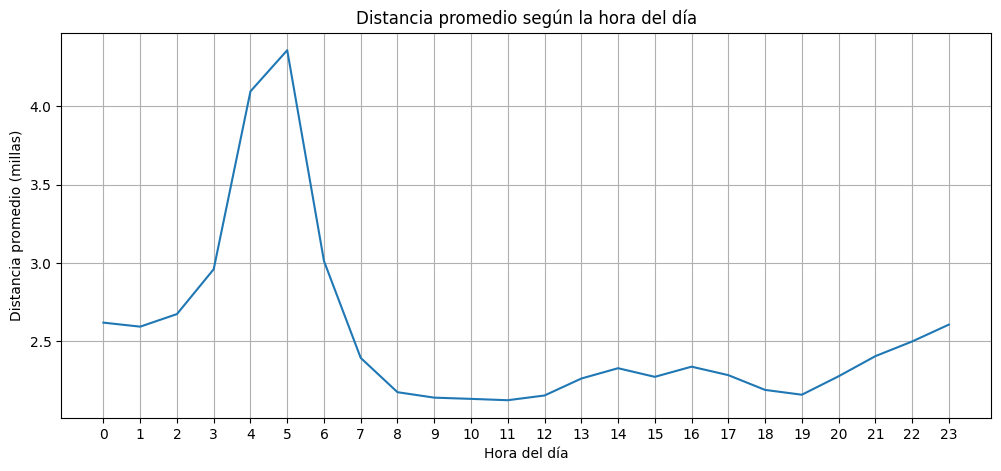

In [36]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=taxiTrimestralData_filtrado, x='pickup_hour', y='trip_distance', estimator='mean', ci=None)
plt.title('Distancia promedio según la hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Distancia promedio (millas)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

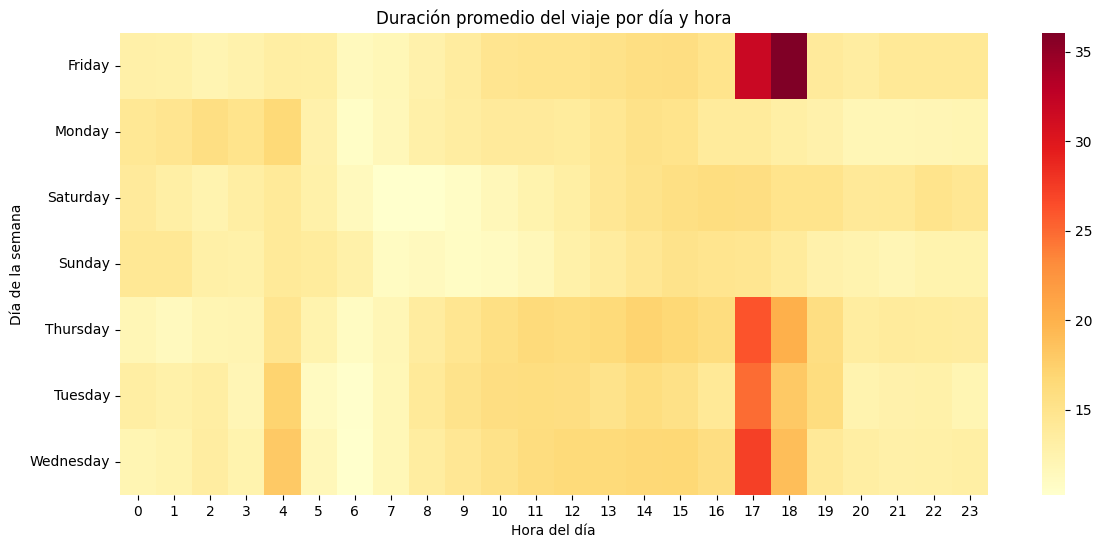

In [38]:
pivot_duracion = taxiTrimestralData_filtrado.pivot_table(
    values='trip_time_min', index='pickup_day', columns='pickup_hour', aggfunc='mean'
)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_duracion, cmap='YlOrRd')
plt.title('Duración promedio del viaje por día y hora')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')
plt.show()